# Test 3 — Improved Training Notebook
This notebook provides a robust, reproducible training pipeline for the drowsiness detection dataset.
It uses tf.data, MobileNetV2 transfer learning, class weighting, callbacks, and a short fine-tuning stage.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import json

In [2]:
# Configuration
BASE_DIR = r"/Users/charinduliyanage17/Documents/GitHub/Research_Test/Dataset"
TRAIN_DIR = os.path.join(BASE_DIR, 'Train')
VAL_DIR = os.path.join(BASE_DIR, 'Val')
# If you have a separate test folder, set TEST_DIR otherwise set to None
TEST_DIR = os.path.join(BASE_DIR, 'Test') if os.path.exists(os.path.join(BASE_DIR, 'Test')) else None
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
print('BASE_DIR:', BASE_DIR)

BASE_DIR: /Users/charinduliyanage17/Documents/GitHub/Research_Test/Dataset


In [3]:
# Load datasets using tf.data utilities (returns batched datasets)
print('Loading datasets...')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)
test_ds = None
if TEST_DIR:
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    )
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print('Found classes (order):', class_names)
print('Num classes:', NUM_CLASSES)

Loading datasets...
Found 8548 files belonging to 4 classes.
Found 1554 files belonging to 4 classes.
Found 1464 files belonging to 4 classes.
Found classes (order): ['Closed_Eyes', 'No_yawn', 'Open_Eyes', 'Yawn']
Num classes: 4


In [4]:
# Data preprocessing & augmentation pipeline (fast, on-the-fly)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])

def preprocess(images, labels):
    # images are uint8 in [0,255] - convert to float32 and apply model preprocess
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)  # mobilenet_v2 preprocessing -> scales to [-1,1]
    return images, labels

def augment(images, labels):
    images = data_augmentation(images)
    return images, labels

# Apply augmentation only to training dataset and optimize pipelines
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

if test_ds is not None:
    test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

print('Datasets prepared.')

Datasets prepared.


In [5]:
# Compute class weights to handle imbalance (if any)
# Extract labels from the (unbatched) train dataset to compute weights
y_train = []
for images, labels in tf.data.Dataset.from_generator(lambda: train_ds.unbatch(), output_signature=(tf.TensorSpec(shape=(None,None,3), dtype=tf.float32), tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32))):
    pass
# The above attempt to re-use the generator can be unreliable; instead collect labels by iterating over the original image_dataset_from_directory output
y_labels = []
for batch_images, batch_labels in tf.keras.utils.image_dataset_from_directory(TRAIN_DIR, label_mode='categorical', image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED):
    y_labels.extend(np.argmax(batch_labels.numpy(), axis=1).tolist())

class_weights = dict()
if len(y_labels) > 0:
    classes = np.unique(y_labels)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_labels)
    class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print('Computed class weights:', class_weights)

Found 8548 files belonging to 4 classes.


2025-11-16 23:26:01.766224: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-16 23:26:01.792833: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Computed class weights: {0: 1.0532281912272055, 1: 0.9870669745958429, 2: 0.9696007259528131, 3: 0.9939534883720931}


In [6]:
# Build model: MobileNetV2 base + lightweight classification head
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze for initial training

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = inputs
x = preprocess_input(x)  # allow passing raw images to this model if needed
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [7]:
# Training callbacks
checkpoint_path = 'test3_best_model.h5'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.CSVLogger('test3_training_log.csv')
]

# Initial training: head only
INITIAL_EPOCHS = 12
history = model.fit(train_ds, epochs=INITIAL_EPOCHS, validation_data=val_ds, callbacks=callbacks, class_weight=class_weights)

print('Initial training finished')

Epoch 1/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2936 - loss: 1.7285 - top_2_accuracy: 0.5424
Epoch 1: val_loss improved from inf to 1.50546, saving model to test3_best_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.2936 - loss: 1.7279 - top_2_accuracy: 0.5425 - val_accuracy: 0.4717 - val_loss: 1.5055 - val_top_2_accuracy: 0.6100 - learning_rate: 0.0010
Epoch 2/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3417 - loss: 1.3885 - top_2_accuracy: 0.6092
Epoch 2: val_loss improved from 1.50546 to 1.44393, saving model to test3_best_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.3418 - loss: 1.3884 - top_2_accuracy: 0.6092 - val_accuracy: 0.3012 - val_loss: 1.4439 - val_top_2_accuracy: 0.7342 - learning_rate: 0.0010
Epoch 3/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3627 - loss: 1.3249 - top_2_accuracy: 0.6111
Epoch 3: val_loss improved from 1.44393 to 1.29106, saving model to test3_best_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.3628 - loss: 1.3249 - top_2_accuracy: 0.6112 - val_accuracy: 0.4923 - val_loss: 1.2911 - val_top_2_accuracy: 0.8127 - learning_rate: 0.0010
Epoch 4/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3715 - loss: 1.2898 - top_2_accuracy: 0.6463
Epoch 4: val_loss did not improve from 1.29106
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.3715 - loss: 1.2898 - top_2_accuracy: 0.6463 - val_accuracy: 0.3533 - val_loss: 1.3612 - val_top_2_accuracy: 0.8456 - learning_rate: 0.0010
Epoch 5/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3860 - loss: 1.2679 - top_2_accuracy: 0.6660
Epoch 5: val_loss improved from 1.29106 to 1.16049, saving model to test3_best_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.3860 - loss: 1.2679 - top_2_accuracy: 0.6660 - val_accuracy: 0.5508 - val_loss: 1.1605 - val_top_2_accuracy: 0.8475 - learning_rate: 0.0010
Epoch 6/12
Epoch 6/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3819 - loss: 1.2764 - top_2_accuracy: 0.6559
Epoch 6: val_loss did not improve from 1.16049
268/268 ━━━━━━━━━━━━━━━━━━━━ 46s 170ms/step - accuracy: 0.3820 - loss: 1.2764 - top_2_accuracy: 0.6560 - val_accuracy: 0.4524 - val_loss: 1.3010 - val_top_2_accuracy: 0.7452 - learning_rate: 0.0010
Epoch 7/12

Epoch 6: val_loss did not improve from 1.16049
268/268 ━━━━━━━━━━━━━━━━━━━━ 46s 170ms/step - accuracy: 0.3820 - loss: 1.2764 - top_2_accuracy: 0.6560 - val_accuracy: 0.4524 - val_loss: 1.3010 - val_top_2_accuracy: 0.7452 - learning_rate: 0.0010
Epoch 7/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3750 - loss: 1.2737 - top_2_accuracy: 0.6627
Epoch 7: val_loss improved from 1.16049 to 1.13502, saving mode

268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - accuracy: 0.3751 - loss: 1.2737 - top_2_accuracy: 0.6627 - val_accuracy: 0.4569 - val_loss: 1.1350 - val_top_2_accuracy: 0.8983 - learning_rate: 0.0010
Epoch 8/12
Epoch 8/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3895 - loss: 1.2508 - top_2_accuracy: 0.6784
Epoch 8: val_loss improved from 1.13502 to 1.09000, saving model to test3_best_model.h5

Epoch 8: val_loss improved from 1.13502 to 1.09000, saving model to test3_best_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 181ms/step - accuracy: 0.3895 - loss: 1.2508 - top_2_accuracy: 0.6784 - val_accuracy: 0.5154 - val_loss: 1.0900 - val_top_2_accuracy: 0.8880 - learning_rate: 0.0010
Epoch 9/12
Epoch 9/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4168 - loss: 1.2461 - top_2_accuracy: 0.6835
Epoch 9: val_loss did not improve from 1.09000
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - accuracy: 0.4168 - loss: 1.2461 - top_2_accuracy: 0.6835 - val_accuracy: 0.5026 - val_loss: 1.2178 - val_top_2_accuracy: 0.9041 - learning_rate: 0.0010
Epoch 10/12

Epoch 9: val_loss did not improve from 1.09000
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - accuracy: 0.4168 - loss: 1.2461 - top_2_accuracy: 0.6835 - val_accuracy: 0.5026 - val_loss: 1.2178 - val_top_2_accuracy: 0.9041 - learning_rate: 0.0010
Epoch 10/12
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3988 - loss: 1.2589 - top_2_accuracy: 0.6793
Epoch 10: val_loss did not improve from 1.09000
268/268 ━━━━━

In [8]:
# Fine-tuning: unfreeze last layers of base model and train with a low LR
# Unfreeze from a certain layer to allow some representation learning
UNFREEZE_AT = 100  # layer index to start unfreezing (tune as needed)
for layer in base_model.layers[UNFREEZE_AT:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

FINE_TUNE_EPOCHS = 12
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch=INITIAL_EPOCHS, validation_data=val_ds, callbacks=callbacks, class_weight=class_weights)

print('Fine-tuning finished')

Epoch 13/24
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.4959 - loss: 1.1626 - top_2_accuracy: 0.7977
Epoch 13: val_loss did not improve from 1.09000

Epoch 13: val_loss did not improve from 1.09000
268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 262ms/step - accuracy: 0.4962 - loss: 1.1620 - top_2_accuracy: 0.7979 - val_accuracy: 0.2162 - val_loss: 3.9215 - val_top_2_accuracy: 0.5618 - learning_rate: 1.0000e-05
Epoch 14/24
268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 262ms/step - accuracy: 0.4962 - loss: 1.1620 - top_2_accuracy: 0.7979 - val_accuracy: 0.2162 - val_loss: 3.9215 - val_top_2_accuracy: 0.5618 - learning_rate: 1.0000e-05
Epoch 14/24
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6788 - loss: 0.7833 - top_2_accuracy: 0.9097
Epoch 14: val_loss did not improve from 1.09000

Epoch 14: val_loss did not improve from 1.09000
268/268 ━━━━━━━━━━━━━━━━━━━━ 76s 284ms/step - accuracy: 0.6789 - loss: 0.7832 - top_2_accuracy: 0.9097 - val_accuracy: 0.2175 - val_loss: 3.4733 - val_top_2_accur

Evaluating on: test
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.1359 - loss: 1.7609 - top_2_accuracy: 0.4190
Evaluation results: [1.767214298248291, 0.12704917788505554, 0.4330601096153259]
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.1359 - loss: 1.7609 - top_2_accuracy: 0.4190
Evaluation results: [1.767214298248291, 0.12704917788505554, 0.4330601096153259]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms

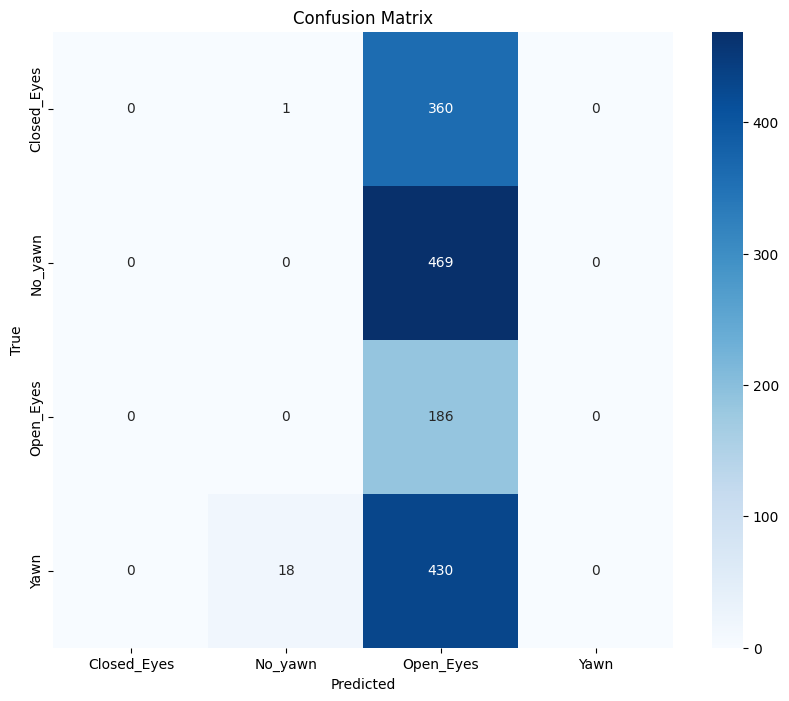

/Users/charinduliyanage17/Documents/GitHub/Research_Test/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/charinduliyanage17/Documents/GitHub/Research_Test/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/charinduliyanage17/Documents/GitHub/Research_Test/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Classification report:
              precision    recall  f1-score   support

 Closed_Eyes       0.00      0.00      0.00       361
     No_yawn       0.00      0.00      0.00       469
   Open_Eyes       0.13      1.00      0.23       186
        Yawn       0.00      0.00      0.00       448

    accuracy                           0.13      1464
   macro avg       0.03      0.25      0.06      1464
weighted avg       0.02      0.13      0.03      1464

Model saved to test3_final_model
Model saved to test3_final_model


In [10]:
# Evaluate on test / validation set and show confusion matrix
eval_ds = test_ds if test_ds is not None else val_ds
print('Evaluating on:', 'test' if test_ds is not None else 'val')
results = model.evaluate(eval_ds)
print('Evaluation results:', results)

# Predict and compute confusion matrix and classification report
y_true = []
y_pred = []
for images, labels in eval_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(np.argmax(labels.numpy(), axis=1).tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification report:')
print(classification_report(y_true, y_pred, target_names=class_names))

# Save final model (already checkpointed)
model.save('test3_final_model.h5')
print('Model saved to test3_final_model')

## Notes & next steps
- You can tune UNFREEZE_AT, batch size, and learning rates based on GPU/memory.
- For larger datasets prefer a bigger batch_size and longer training.
- Consider using mixed precision if you have a compatible GPU: `tf.keras.mixed_precision.set_global_policy('mixed_float16')`.
- Update `requirements.txt` to pin package versions used in your environment.

Preparing improved training pipeline: mixup + label smoothing + extended fine-tuning
Improved train pipeline prepared (mixup + stronger augmentation).
Compiling model with label smoothing...
Starting initial training for 20 epochs...
Epoch 1/20
Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2503 - loss: 1.4940 - top_2_accuracy: 0.5047
Epoch 1: val_loss did not improve from 1.09000

Epoch 1: val_loss did not improve from 1.09000
268/268 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.2503 - loss: 1.4938 - top_2_accuracy: 0.5046 - val_accuracy: 0.2928 - val_loss: 1.5156 - val_top_2_accuracy: 0.5090 - learning_rate: 0.0010
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.2503 - loss: 1.4938 - top_2_accuracy: 0.5046 - val_accuracy: 0.2928 - val_loss: 1.5156 - val_top_2_accuracy: 0.5090 - learning_rate: 0.0010
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2450 - loss: 1.3989 - top_2_accuracy: 0.4936
Epoch 2: val_loss did not i

2025-11-17 01:14:08.305656: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


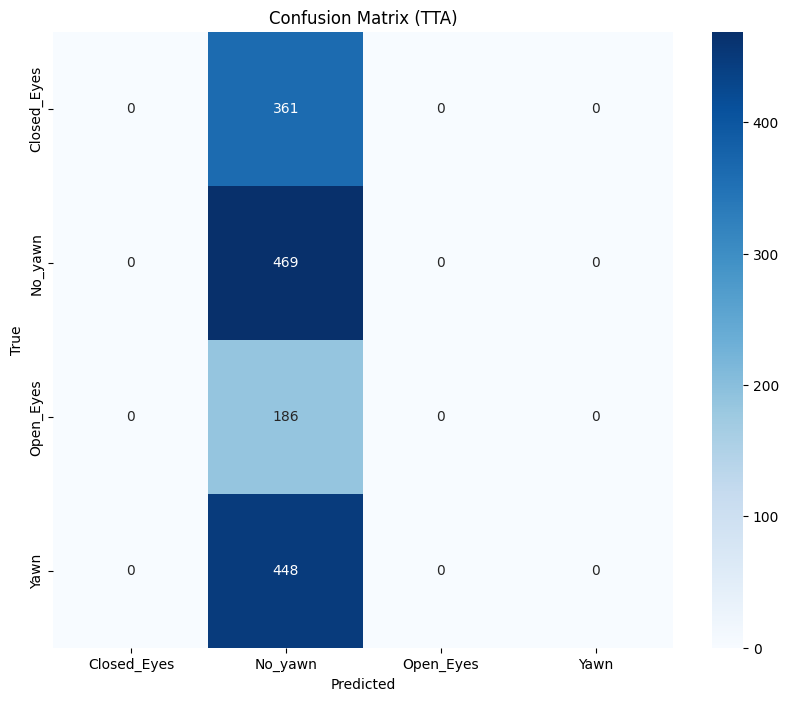

/Users/charinduliyanage17/Documents/GitHub/Research_Test/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/charinduliyanage17/Documents/GitHub/Research_Test/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/charinduliyanage17/Documents/GitHub/Research_Test/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param


Classification report (TTA):
              precision    recall  f1-score   support

 Closed_Eyes       0.00      0.00      0.00       361
     No_yawn       0.32      1.00      0.49       469
   Open_Eyes       0.00      0.00      0.00       186
        Yawn       0.00      0.00      0.00       448

    accuracy                           0.32      1464
   macro avg       0.08      0.25      0.12      1464
weighted avg       0.10      0.32      0.16      1464

Saved model to test3_final_model_v2


: 

In [ ]:
# === Accuracy improvement cell ===
# Mixup, label smoothing, stronger augmentation, longer training and expanded fine-tuning
import tensorflow as tf
import numpy as np

print('Preparing improved training pipeline: mixup + label smoothing + extended fine-tuning')

# 1) Mixup helper (uses numpy for Beta sampling, wrapped for TF pipeline)
def _mixup_numpy(images, labels, alpha=0.2):
    # images: (batch, H, W, C), labels: (batch, num_classes)
    if alpha <= 0:
        return images, labels
    lam = np.random.beta(alpha, alpha)
    batch_size = images.shape[0]
    index = np.random.permutation(batch_size)
    mixed_images = lam * images + (1.0 - lam) * images[index]
    mixed_labels = lam * labels + (1.0 - lam) * labels[index]
    return mixed_images.astype(np.float32), mixed_labels.astype(np.float32)


def mixup_batch(images, labels, alpha=0.2):
    mixed_images, mixed_labels = tf.numpy_function(func=_mixup_numpy, inp=[images, labels, alpha], Tout=[tf.float32, tf.float32])
    # restore static shape information
    mixed_images.set_shape(images.shape)
    mixed_labels.set_shape(labels.shape)
    return mixed_images, mixed_labels

# 2) Stronger on-the-fly augmentation (added brightness/contrast/gaussian-ish noise)
data_augmentation_improved = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.12),
    tf.keras.layers.RandomZoom(0.12),
    tf.keras.layers.RandomContrast(0.12),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

# Insert the improved augmentation into the pipeline
# Note: train_ds is expected to already exist (from earlier cells). We'll create a new pipeline
try:
    # re-create training pipeline: preprocess (mobilenet), augment, mixup, cache/shuffle/prefetch
    def preprocess_fn(images, labels):
        images = tf.cast(images, tf.float32)
        images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
        return images, labels

    def augment_fn(images, labels):
        images = data_augmentation_improved(images)
        return images, labels

    # Apply in this order: preprocess -> augment -> mixup -> cache/shuffle/prefetch
    train_ds_improved = train_ds.map(preprocess_fn, num_parallel_calls=AUTOTUNE)
    train_ds_improved = train_ds_improved.map(augment_fn, num_parallel_calls=AUTOTUNE)
    # apply mixup with alpha=0.2
    train_ds_improved = train_ds_improved.map(lambda x, y: mixup_batch(x, y, 0.2), num_parallel_calls=AUTOTUNE)
    train_ds_improved = train_ds_improved.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)

    # validation/test: just preprocess (should already be set up as val_ds)
    val_ds_prepped = val_ds  # already preprocessed in previous pipeline

    print('Improved train pipeline prepared (mixup + stronger augmentation).')
except NameError as e:
    print('train_ds or related variables not found in the notebook environment. Run data-loading cells first.')
    raise

# 3) Label smoothing loss (helps generalization slightly)
label_smoothing = 0.07
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

# 4) Rebuild/compile model head with the loss; keep base frozen for initial training
print('Compiling model with label smoothing...')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

# 5) Increase initial epochs and fine-tune longer
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 30

# callbacks (reuse existing callbacks list if available, otherwise create)
try:
    callbacks  # noqa: F821
except NameError:
    checkpoint_path = 'test3_best_model.h5'
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.CSVLogger('test3_training_log.csv')
    ]

print(f'Starting initial training for {INITIAL_EPOCHS} epochs...')
history = model.fit(train_ds_improved, epochs=INITIAL_EPOCHS, validation_data=val_ds_prepped, callbacks=callbacks, class_weight=class_weights)

print('Initial training done — now expanding fine-tuning')

# 6) Fine-tuning: unfreeze more of the base model and train with a low LR and longer schedule
UNFREEZE_AT = 50  # unfreeze from this layer index; tune if needed
for layer in base_model.layers[UNFREEZE_AT:]:
    layer.trainable = True

# recompile with a lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss=loss_fn,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
print(f'Fine-tuning for additional {FINE_TUNE_EPOCHS} epochs (total epochs = {total_epochs})')
history_fine = model.fit(train_ds_improved, epochs=total_epochs, initial_epoch=INITIAL_EPOCHS, validation_data=val_ds_prepped, callbacks=callbacks, class_weight=class_weights)

print('Fine-tuning finished')

# 7) Optional: simple Test-Time Augmentation (TTA) evaluation to potentially boost final accuracy
print('Running TTA evaluation on validation/test set (simple horizontal flips)')
eval_ds = test_ds if 'test_ds' in globals() and test_ds is not None else val_ds_prepped

def tta_predict(model, dataset, tta_transforms=2):
    preds_all = []
    for t in range(tta_transforms):
        preds_batch = []
        for images, labels in dataset:
            if t == 1:
                # simple horizontal flip TTA
                images_t = tf.image.flip_left_right(images)
            else:
                images_t = images
            preds = model.predict(images_t, verbose=0)
            preds_batch.append(preds)
        preds_all.append(np.vstack(preds_batch))
    # average predictions
    avg_preds = np.mean(preds_all, axis=0)
    return avg_preds

avg_preds = tta_predict(model, eval_ds, tta_transforms=2)
# collect y_true
y_true = []
y_pred = []
idx = 0
for images, labels in eval_ds:
    batch_size_cur = images.shape[0]
    y_true.extend(np.argmax(labels.numpy(), axis=1).tolist())
    y_pred.extend(np.argmax(avg_preds[idx: idx + batch_size_cur], axis=1).tolist())
    idx += batch_size_cur

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
acc = accuracy_score(y_true, y_pred)
print('TTA accuracy:', acc)

cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (TTA)')
plt.show()

print('\nClassification report (TTA):')
print(classification_report(y_true, y_pred, target_names=class_names))

# Save final model and training histories
model.save('test3_final_model_v2.h5')
print('Saved model to test3_final_model_v2')
